In [1]:
from create_data import DumbCirc as dc
from gpydkl import DKLGPy as dg
import matplotlib
import matplotlib.pyplot as plt

In [2]:
data_instance = dc(0.5, 0.5, 0.25, 22)
fpc, fnc, pc, lp, tc, lt = data_instance.create_dataset(50, 2, [50], [0.2], True)

In [3]:
import torch
torch.manual_seed(22)
fpc, fnc, pc, lp, tc, lt = torch.tensor(fpc), torch.tensor(fnc), torch.tensor(pc), torch.tensor(lp), torch.tensor(tc), torch.tensor(lt)

In [4]:
mdg = dg(point_cloud=fpc, partial_cloud=pc, test_partial=tc, train_labels=lp, test_labels=lt, negative_cloud=fnc, count_labels=2)

In [5]:
use_cuda = torch.cuda.is_available()
#device = torch.device("cuda" if use_cuda else "cpu")
device = "cpu"
mdg.set_device(device)

In [6]:
x, y = mdg.get_gp_data()

In [7]:
mapper = mdg.map_network

In [8]:
kernel_dim = mdg.mapping_dim

In [9]:
import gpytorch
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=kernel_dim))
            self.map_network = mapper

            self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            projected_x = self.map_network(x)
            projected_x = self.scale_to_bounds(projected_x) 

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [10]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(x, y, likelihood)

In [11]:
from tqdm.notebook import tqdm
training_iterations = 10

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.map_network.parameters()},
    {'params': model.covar_module.parameters()},
    {'params': model.mean_module.parameters()},
    {'params': model.likelihood.parameters()},
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def train():
    iterator = tqdm(range(training_iterations))
    for i in iterator:
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(x)
        # Calc loss and backprop derivatives
        loss = -mll(output, y)
        loss.backward()
        iterator.set_postfix(loss=loss.item())
        optimizer.step()

train()

  0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds = model(x[:35])

In [13]:
model.covar_module(model.map_network(x[:35])).evaluate_kernel().to_dense()

tensor([[6.6299e-01, 3.3701e-02, 1.0108e-02,  ..., 4.0919e-01, 1.1697e-03,
         3.2736e-01],
        [3.3701e-02, 6.6299e-01, 5.9680e-01,  ..., 2.2540e-01, 3.4808e-01,
         9.6481e-04],
        [1.0108e-02, 5.9680e-01, 6.6299e-01,  ..., 1.0545e-01, 5.2412e-01,
         1.6975e-04],
        ...,
        [4.0919e-01, 2.2540e-01, 1.0545e-01,  ..., 6.6299e-01, 2.3706e-02,
         6.3302e-02],
        [1.1697e-03, 3.4808e-01, 5.2412e-01,  ..., 2.3706e-02, 6.6299e-01,
         8.7288e-06],
        [3.2736e-01, 9.6481e-04, 1.6975e-04,  ..., 6.3302e-02, 8.7288e-06,
         6.6299e-01]], grad_fn=<MulBackward0>)

In [14]:
test_x = mdg.get_test_data()

In [15]:
test_x.shape

torch.Size([2, 10000, 4])

In [16]:
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds = model(test_x[0])

In [17]:
model.covar_module(model.map_network(test_x[0])).evaluate_kernel().to_dense()

tensor([[0.6630, 0.6622, 0.6599,  ..., 0.1417, 0.1473, 0.1530],
        [0.6622, 0.6630, 0.6622,  ..., 0.1538, 0.1597, 0.1657],
        [0.6599, 0.6622, 0.6630,  ..., 0.1665, 0.1727, 0.1790],
        ...,
        [0.1417, 0.1538, 0.1665,  ..., 0.6630, 0.6628, 0.6621],
        [0.1473, 0.1597, 0.1727,  ..., 0.6628, 0.6630, 0.6628],
        [0.1530, 0.1657, 0.1790,  ..., 0.6621, 0.6628, 0.6630]],
       grad_fn=<MulBackward0>)

Text(0.5, 1.0, 'Probability of being on the surface')

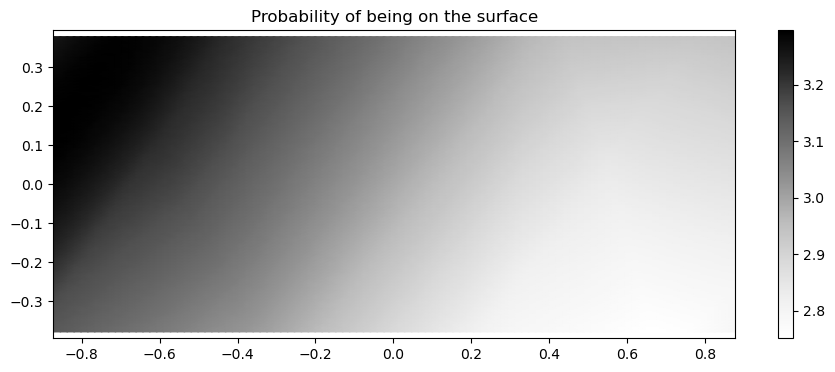

In [18]:
import numpy as np
from scipy.stats import norm
posterior_mean = preds.mean
posterior_diag = preds.stddev
with torch.no_grad():
    prob_on_surface = norm.pdf(np.zeros(posterior_mean.shape), loc=posterior_mean.cpu().detach().numpy(),
                               scale=np.sqrt(posterior_diag.cpu().detach().numpy()))
gp = test_x[0].cpu().numpy()
gp_x = gp[:, 0].reshape(mdg.grid_sizes)
gp_y = gp[:, 1].reshape(mdg.grid_sizes)
gp_prob = prob_on_surface.reshape(mdg.grid_sizes)

fig = plt.figure(figsize=(11, 4))
ax = fig.add_subplot(111)
plot = ax.pcolormesh(gp_x, gp_y, gp_prob, shading='gouraud', cmap='Greys')
#ax.scatter(self.test_partial[i].cpu().numpy()[:, 0], self.test_partial[i].cpu().numpy()[:, 1], c='r', s=1)
fig.colorbar(plot)
ax.axis('equal')
ax.set_title(f'Probability of being on the surface')